In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Compute the damped anomaly and add it to the climatological trend 
uses weekly aggregated obs
must have alphas computed already
must have ClimoTrend computed already
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics
import dask
import xskillscore as xs

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# Damped Anomaly CC's method 

In [3]:
# from dask.distributed import Client
# client = Client(n_workers=2)
# client = Client()
# client
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
# dask.config.set(scheduler='processes')  # overwrite default with threaded scheduler

In [4]:
# Parameters
cmod = 'dampedAnomalyTrend'
runType = 'forecast'

today_date = datetime.datetime.now()
pred_year =  today_date.year # Prediction year
#pred_year = 2018  # can force to do an old year

Y_Start = 1990
Y_End = 2017  # for the alpha file (okay to be a bit outdated)

E = ed.EsioData.load()
mod_dir = E.model_dir
print(pred_year)


2019


In [5]:
#############################################################
# Load in Obs and Climo Trend Data 
#############################################################

# Get daily obs for init_time
obs = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/'+str(pred_year)+'.nc', concat_dim='time', autoclose=True, parallel=True).sic
obs = obs.drop('hole_mask')

# Get daily climo trend, first for all times 
files_in = os.path.join(mod_dir, 'climatology', runType, 'sipn_nc/*.nc')
climo = xr.open_mfdataset(files_in, concat_dim='time', autoclose=True, parallel=True)
climo = climo.sel(time=slice(str(pred_year),str(pred_year+50)))  # limit to pred year and forward

#print('obs ',obs)
print('climo', climo)

climo <xarray.Dataset>
Dimensions:  (time: 600, x: 304, y: 448)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-08-22
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 228 229 230 231 232 233 234 235
Data variables:
    sic      (time, y, x) float64 dask.array<shape=(600, 448, 304), chunksize=(1, 448, 304)>


In [6]:
# compute obs anomaly of pred_year
anom = obs - climo.sel(time=obs.time) # limit to the init_time
anom = anom.swap_dims({'time':'doy'})

print('anom ',anom)

anom  <xarray.Dataset>
Dimensions:  (doy: 232, x: 304, y: 448)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    time     (doy) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-08-20
  * doy      (doy) int64 1 2 3 4 5 6 7 8 9 ... 225 226 227 228 229 230 231 232
Data variables:
    sic      (doy, y, x) float64 dask.array<shape=(232, 448, 304), chunksize=(1, 448, 304)>


In [7]:
# now change the first dimension of climo to be a number relative to 1, call it abs_doy
atime = np.arange(1,len(climo.time)+1)   # absolute doy
climo.coords['abs_doy'] = xr.DataArray(atime, dims='time', coords={'time':climo.time})
climo = climo.drop('doy')
climo = climo.swap_dims({'time':'abs_doy'})
print('climo ', climo)


climo  <xarray.Dataset>
Dimensions:  (abs_doy: 600, x: 304, y: 448)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    time     (abs_doy) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-08-22
  * abs_doy  (abs_doy) int64 1 2 3 4 5 6 7 8 ... 593 594 595 596 597 598 599 600
Data variables:
    sic      (abs_doy, y, x) float64 dask.array<shape=(600, 448, 304), chunksize=(1, 448, 304)>


In [8]:
# get alpha made for weekly anomalies
file_in = os.path.join(mod_dir, cmod, runType, 'param_weekly', str(Y_Start)+'_'+str(Y_End)+'_Alpha.nc')
print(file_in)
alpha = xr.open_mfdataset(file_in, autoclose=True, parallel=True).alpha
 # Add cords
alpha.coords['fore_doy'] = alpha['fore_time']*7-3
alpha.coords['init_doy'] = alpha['init_time']*7-3
#print(alpha)

/home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/param_weekly/1990_2017_Alpha.nc


In [9]:
oceanmask = anom.isel(doy=0).notnull().drop(['doy','time']).sic
print(oceanmask)

<xarray.DataArray 'sic' (y: 448, x: 304)>
dask.array<shape=(448, 304), dtype=bool, chunksize=(448, 304)>
Coordinates:
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303


In [10]:
UpdateAll = False
#UpdateAll = True
tmp = None

# send this a specificdate and it returns the nearest date in the array of manydates
def nearest(manydates, specificdate):
    return min(manydates, key=lambda x: abs(x - specificdate))


In [11]:
# init_time is by doy relative to jan 1 of pred year
# fore_time is relative to init_time so fore_time = 0 is equal to the init_tim

# loop over the init_time that we want to predict within predict_year

last_fore = 220 # gets us through 7 months

alphadoylast = np.nan  
#for cdoy in [10]:
for cdoy in anom.doy.values:
    
    # select anom for this cdoy 
    # anom has dim cdoy relative to jan 1 of prediction year
    c_anomaly = anom.sel(doy=cdoy)  # anomaly of the init time
    time_hold = c_anomaly.time # keep a copy of the init_time actual time 
    c_anomaly = c_anomaly.drop(['doy','time']) # but get rid all reference to time/doy
#    print('c_anomaly ',c_anomaly)
    datestring=pd.to_datetime(time_hold.item()).strftime('%Y-%m-%d')

    file_out = os.path.join(mod_dir, cmod, runType, 'sipn_nc', datestring+'.nc')
#    print(file_out)
    
    # Only calc if it doesn't exist or if last doy of pred_year
    if (os.path.isfile(file_out) & (cdoy<anom.doy.max()) & ~UpdateAll):
        print('skipping ',file_out)
        continue

    # fore_climo is all climo for all doys relative to Jan 1 we are trying to forecast
    fore_climo = climo.sel(abs_doy=slice(cdoy,cdoy+last_fore))  # tryto forecast 0 to 366 doys from init_time
    fore_climo = fore_climo.drop('time')
#    print('fore_climo in abs_doy',fore_climo)
    # how many days are we actually going to be able to forecast?
    maxclimodoys =len(fore_climo.abs_doy) # limited to data on hand, <= 366
    # ftimes (aka fore_time for all days) is doy relative to cdoy (0 to <=366)
    ftimes = np.arange(0,maxclimodoys,1)    
    fore_climo.coords['fore_doy'] = xr.DataArray(ftimes, dims='abs_doy', coords={'abs_doy':fore_climo.abs_doy})
    fore_climo = fore_climo.swap_dims({'abs_doy':'fore_doy'})
    fore_climo = fore_climo.drop('abs_doy')
#    print('fore_climo in fore_doy', fore_climo)

    # from alpha get the nearest init_doy for this cdoy
    # alpha has fore_doy ranging from 4 to 363, note no zero which would be alpha = ones 
    # so will need to interpolate to daily fore_doy 
    alphadoy=nearest(alpha.init_doy.values,cdoy) # the nearest init_doy for this cdoy
    print(cdoy,' is nearest to ', alphadoy, alphadoylast)

    if (alphadoy != alphadoylast):   # must interpolate a new c_alpha
        print('    get next alpha and interpolate')
        c_alpha = alpha.where(alpha.init_doy==alphadoy,drop=True).drop(['init_time','init_doy']) # select the right init_time
        c_alpha = c_alpha[0,:,:,:]  # gets rid of weird dim problem

        # add 0 and 366 doy for interpolation
        c_zero = c_alpha[0,:,:]
        c_zero = (c_zero>0).astype('int')
        c_zero = c_zero.where(oceanmask)
        c_zero = c_zero.expand_dims('fore_time')
        c_zero.fore_time[0] = 0
        c_zero['fore_doy'] = 0
        c_last = c_alpha[-1,:,:]
        c_last = c_last.expand_dims('fore_time')
        c_last.fore_time[-1] = 53
        c_last['fore_doy'] = 366
        c_alpha = xr.concat([c_zero,c_alpha,c_last],dim='fore_time')

        c_alpha = c_alpha.swap_dims({'fore_time':'fore_doy'})
        c_alpha = c_alpha.drop('fore_time')

    #    print('c_zero ',c_zero[90,130:].values)
    #    print('c_alpha ',c_alpha[0,90,130:].values)

        if c_alpha.chunks:
            # chunk in y not time for interpolation since >1 not allowed yet
            c_alpha = c_alpha.chunk({'fore_doy': -1,'y' : 1})
        c_alpha = c_alpha.interp(fore_doy=ftimes)
    #    print('c_alpha ',c_alpha)
        alphadoylast = alphadoy
        if c_alpha.chunks:
            c_alpha = c_alpha.chunk({'fore_doy': 1,'y' : -1})
        c_alpha.load()

    # predict just the damped anomaly first
    predict = c_anomaly * c_alpha  # forecast without zero time always has 52 doys
    predict = predict.transpose('fore_doy', 'y','x') # fix order    
    predict_anom = predict.sic  # save for plotting later
    
    # now add the damped anomly to the climo
    predict.load()
    fore_climo.load()
    predict = predict + fore_climo
    predict.coords['init_time'] = time_hold.drop('doy')    
    predict = predict.drop(['xm','ym','time'])
    predict = predict.rename({'fore_doy':'fore_time'})
    predict['fore_time'] = pd.to_timedelta(predict.fore_time.values,unit='d')

#    print('predict ', predict)

    # must limit to [0,1]
    predict=predict.where(predict>0,other=0).where(oceanmask)
    predict=predict.where(predict<1,other=1).where(oceanmask)

    predict = import_data.expand_to_sipn_dims(predict)
    
    predict = predict.rename({'x':'nj','y':'ni'})

#    print('predict for saving ',predict)
                            
    predict.to_netcdf(file_out)
    print("Saved file:",file_out)

skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-01.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-02.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-03.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-04.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-05.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-06.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-07.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-08.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-09.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-01-10.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTre

skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-02.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-03.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-04.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-05.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-06.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-07.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-08.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-09.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-10.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-05-11.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTre

Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-07-28.nc
210  is nearest to  207 207
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-07-29.nc
211  is nearest to  214 207
    get next alpha and interpolate
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-07-30.nc
212  is nearest to  214 214
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-07-31.nc
213  is nearest to  214 214
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-08-01.nc
214  is nearest to  214 214
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-08-02.nc
215  is nearest to  214 214
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-08-03.nc
216  is nearest to  214 214
Saved file: /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc/2019-08-04.nc
2

In [12]:
# set up colors and print some stuff
cmap_diff_2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","white","green"])
cmap_diff_2.set_bad(color = 'lightgrey')
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')

print('cdoy ',cdoy)

init_time_str = pd.to_datetime(time_hold.time.values ).strftime('%Y-%m-%d')
print('Init Time ', init_time_str)

#fore_time_str = (pd.to_datetime(time_hold.time.values) + datetime.timedelta(days=10)).strftime('%Y-%m-%d')
#print('Fore Time 10 days from Init Time', fore_time_str)


cdoy  232
Init Time  2019-08-20


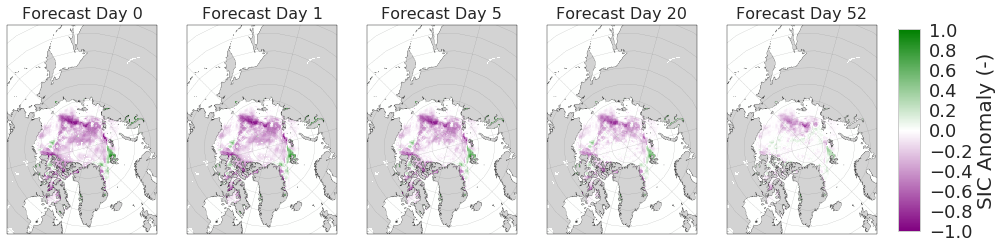

In [13]:
TestPlot = True
if TestPlot:
    c_vmin = -1
    c_vmax = 1

    c_label = 'SIC Anomaly (-)'
    ax_num=0
    p = {}

    (f, axes) = ice_plot.multi_polar_axis(ncols=5, nrows=1, Nplots = 6, sizefcter=2)
    for ftme in [0, 1, 5, 20, 52]:
        p[ax_num]=predict_anom[ftme,:,:].plot(ax=axes[ax_num], x='lon', y='lat', add_colorbar=False,vmin=c_vmin, vmax=c_vmax,
                                             transform=ccrs.PlateCarree(),cmap=cmap_diff_2)
        axes[ax_num].set_title('Forecast Day '+str(ftme), fontsize=16)
        ax_num = ax_num+1

    # Make pretty
    f.subplots_adjust(right=0.93)
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])
    if p: # if its not empty
        cbar = f.colorbar(next(iter(p.values())), cax=cbar_ax, label=c_label) # use first plot to gen colorbar
        cbar.set_ticks(np.arange(-1,1.2,0.2))
        cbar.ax.tick_params(labelsize=18) 
        cbar.set_label(label=c_label,fontsize=20)

    fig_dir = '/home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_figs'
    f_out = os.path.join(fig_dir,'DampedAnomaly_Init_'+init_time_str+'.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

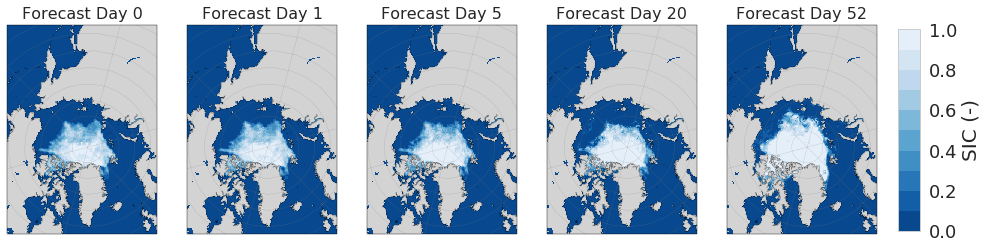

In [14]:
TestPlot = True
if TestPlot:
    
    c_label = 'SIC (-)'
    ax_num=0
    c_vmax=1
    c_vmin =0
    p = {}

    (f, axes) = ice_plot.multi_polar_axis(ncols=5, nrows=1, Nplots = 6, sizefcter=2)
    for ftme in [0, 1, 5, 20, 52]:
        p[ax_num]=predict.sic[0,0,ftme,:,:].plot(ax=axes[ax_num], x='lon', y='lat', add_colorbar=False,vmin=c_vmin, vmax=c_vmax,
                                             transform=ccrs.PlateCarree(),cmap=cmap_sic)
        axes[ax_num].set_title('Forecast Day '+str(ftme), fontsize=16)
        ax_num = ax_num+1

    # Make pretty
    f.subplots_adjust(right=0.93)
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])
    if p: # if its not empty
        cbar = f.colorbar(next(iter(p.values())), cax=cbar_ax, label=c_label) # use first plot to gen colorbar
        cbar.set_ticks(np.arange(-1,1.2,0.2))
        cbar.ax.tick_params(labelsize=18) 
        cbar.set_label(label=c_label,fontsize=20)

    fig_dir = '/home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_figs'
    f_out = os.path.join(fig_dir,'DampedAnomalyTrend_Init_'+init_time_str +'.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300) 

In [15]:
# Test plots for presentations from Nic

In [16]:
test_plots = False

if test_plots:
    fig_dir = '/home/disk/sipn/nicway/Nic/figures/pres/A'

    cmap_diff_2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
    cmap_diff_2.set_bad(color = 'lightgrey')
    cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
    cmap_sic.set_bad(color = 'lightgrey')

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    obs_clim_model.sel(doy=valid_doy).drop('doy').plot(ax=ax, 
                                            x='lon', y='lat', 
                                         transform=ccrs.PlateCarree(),cmap=cmap_sic,
                                                      cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    plt.title('')
    f_out = os.path.join(fig_dir,'Linear_Trend.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    c_anomaly.plot(ax=ax, 
                        x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),cmap=cmap_diff_2,
                                  cbar_kwargs={'label':'SIC Anomaly'})
    plt.title('')
    f_out = os.path.join(fig_dir,'Anomoly.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    alpha_cdoy.sel(doy=cdoy).alpha.plot(ax=ax, 
                        x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),cmap=cmap_diff_2,
                                  cbar_kwargs={'label':'Lag-1 correlation'})
    plt.title('')
    f_out = os.path.join(fig_dir,'Alpha.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)



    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    fore_sic.plot(ax=ax, 
                        x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),cmap=cmap_sic,
                                                      cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    plt.title('')
    f_out = os.path.join(fig_dir,'DampedTrend_Forecast.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

### Compare forecasts to check they make sense